## KNN IMPLEMENTATION

This section contains the Libraries we have used

- pandas for dataframe processes
- sklearn and Scipy for using built-in KNN, cosine similarity and Mean Absolute Error
- Matplotlib for graphing

In [4]:
# Importing libraries
import pandas as pd 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math  
import sklearn.metrics  
from sklearn.metrics import mean_absolute_error

### Step 1: Load the dataset

In [5]:
# Load user ratings
ratings = pd.read_csv('u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])

# Load movie info
movies = pd.read_csv('u.item', sep='|', encoding='latin-1', usecols=[0, 1], names=['movieId', 'title'], header=None)


### Step 2: Undetstand the data

In [6]:
# Check the structure of ratings dataset
ratings.info()

# Check the structure of movies dataset
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   userId     100000 non-null  int64
 1   movieId    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  1682 non-null   int64 
 1   title    1682 non-null   object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


### Step 3: Merge the datasets (To get ratings along with movies)

In [7]:
data = pd.merge(ratings, movies, on='movieId')
print(data.head())


   userId  movieId  rating  timestamp         title
0     196      242       3  881250949  Kolya (1996)
1      63      242       3  875747190  Kolya (1996)
2     226      242       5  883888671  Kolya (1996)
3     154      242       3  879138235  Kolya (1996)
4     306      242       5  876503793  Kolya (1996)


### Step 4:Create a user-item matrix

In [8]:
# Filter users and movies with at least 50 ratings
filtered_users = data['userId'].value_counts()[data['userId'].value_counts() >= 50].index
filtered_movies = data['title'].value_counts()[data['title'].value_counts() >= 50].index

# Filter the data
filtered_data = data[data['userId'].isin(filtered_users) & data['title'].isin(filtered_movies)]

# Create the user-item matrix
user_item_matrix = filtered_data.pivot_table(index='userId', columns='title', values='rating').fillna(0)

print(user_item_matrix.shape)
print(user_item_matrix.head())


(568, 605)
title   101 Dalmatians (1996)  12 Angry Men (1957)  \
userId                                               
1                         2.0                  5.0   
2                         0.0                  0.0   
3                         0.0                  0.0   
5                         2.0                  0.0   
6                         0.0                  4.0   

title   2 Days in the Valley (1996)  20,000 Leagues Under the Sea (1954)  \
userId                                                                     
1                               0.0                                  3.0   
2                               0.0                                  0.0   
3                               0.0                                  0.0   
5                               0.0                                  0.0   
6                               0.0                                  0.0   

title   2001: A Space Odyssey (1968)  39 Steps, The (1935)  \
userId         

### Step 5: Implement KNN for recommendations

In [9]:
from sklearn.neighbors import NearestNeighbors

# Fit the KNN model
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(user_item_matrix.values)

# Choose a user and find similar users
user_index = 0  # Example: first user
user_data = user_item_matrix.iloc[user_index].values.reshape(1, -1)
distances, indices = knn.kneighbors(user_data, n_neighbors=6)

# Display similar users
print("Similar Users:", indices.flatten())
print("Distances:", distances.flatten())


Similar Users: [  0 550  58 517 165 272]
Distances: [0.         0.37335176 0.39933066 0.40068295 0.40097448 0.40320089]


In [10]:
similar_users = indices.flatten()[1:]  
recommended_items = user_item_matrix.iloc[similar_users].mean().sort_values(ascending=False)  
unseen_items = recommended_items[user_item_matrix.iloc[user_index] == 0]  
print("Recommended Items:", unseen_items.head(5))

#Recommend Items to Users:it builds directly on the "distances" and "indices" you just calculated.

Recommended Items: title
Schindler's List (1993)                                                        4.2
Heat (1995)                                                                    4.2
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)    4.0
Heathers (1989)                                                                4.0
Clear and Present Danger (1994)                                                3.8
dtype: float64


In [11]:
ranked_recommendations = unseen_items.sort_values(ascending=False).head(5)  
print("Top Recommendations:", ranked_recommendations)

#Implement Ranking: prioritize top-rated suggestions.

Top Recommendations: title
Schindler's List (1993)                                                        4.2
Heat (1995)                                                                    4.2
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)    4.0
Heathers (1989)                                                                4.0
Clear and Present Danger (1994)                                                3.8
dtype: float64


In [12]:
popular_items = user_item_matrix.mean().sort_values(ascending=False).head(5)  
print("Cold Start Recommendations:", popular_items)

#Handle Cold Start: as a fallback for new users.

Cold Start Recommendations: title
Star Wars (1977)                    3.563380
Fargo (1996)                        2.919014
Raiders of the Lost Ark (1981)      2.899648
Return of the Jedi (1983)           2.866197
Silence of the Lambs, The (1991)    2.702465
dtype: float64


### Step 6: Calculate similarity metrics

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform, euclidean

# Cosine similarity
cosine_sim = cosine_similarity(user_item_matrix)
print("Cosine Similarity", cosine_sim)

# Euclidean distance
euclidean_dist = squareform(pdist(user_item_matrix, metric='euclidean'))
print("Euclidean distance", euclidean_dist)

# Manhattan distance
manhattan_dist = squareform(pdist(user_item_matrix, metric='cityblock'))
print(manhattan_dist)


Cosine Similarity [[1.         0.17368217 0.05629163 ... 0.33822892 0.19984534 0.44193099]
 [0.17368217 1.         0.12898828 ... 0.24016753 0.19033835 0.11625549]
 [0.05629163 0.12898828 1.         ... 0.17911552 0.15751178 0.03118025]
 ...
 [0.33822892 0.24016753 0.17911552 ... 1.         0.28017658 0.25694918]
 [0.19984534 0.19033835 0.15751178 ... 0.28017658 1.         0.2029508 ]
 [0.44193099 0.11625549 0.03118025 ... 0.25694918 0.2029508  1.        ]]
Euclidean distance [[ 0.         61.37589103 61.57921727 ... 58.30094339 63.13477647
  56.39148872]
 [61.37589103  0.         33.06055051 ... 40.98780306 42.01190308
  50.44799302]
 [61.57921727 33.06055051  0.         ... 38.58756276 38.70400496
  48.49742261]
 ...
 [58.30094339 40.98780306 38.58756276 ...  0.         43.89760814
  50.10987927]
 [63.13477647 42.01190308 38.70400496 ... 43.89760814  0.
  51.67204273]
 [56.39148872 50.44799302 48.49742261 ... 50.10987927 51.67204273
   0.        ]]
[[  0. 947. 948. ... 889. 984. 848.

### Step 7: Evaluate the model

In [14]:
from sklearn.metrics import mean_squared_error

# Get actual and predicted ratings for a user
actual_ratings = user_item_matrix.iloc[user_index].values
predicted_ratings = np.mean(user_item_matrix.iloc[indices.flatten()[1:]], axis=0)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print("RMSE:", rmse)

# Precision and recall evaluation
def precision_recall_at_k(actual, predicted, k=5):
    predicted = predicted[:k]
    hits = len(set(actual).intersection(set(predicted)))
    precision = hits / k
    recall = hits / len(actual) if len(actual) > 0 else 0
    return precision, recall

# Example usage
actual_items = np.where(actual_ratings > 0)[0]
predicted_items = np.argsort(predicted_ratings)[::-1]
precision, recall = precision_recall_at_k(actual_items, predicted_items)
print(f"Precision: {precision}, Recall: {recall}")# Get actual and predicted ratings for a user
actual_ratings = user_item_matrix.iloc[user_index].values
predicted_ratings = np.mean(user_item_matrix.iloc[indices.flatten()[1:]], axis=0)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print("RMSE:", rmse)

# Precision and recall evaluation
def precision_recall_at_k(actual, predicted, k=5):
    predicted = predicted[:k]
    hits = len(set(actual).intersection(set(predicted)))
    precision = hits / k
    recall = hits / len(actual) if len(actual) > 0 else 0
    return precision, recall

# Example usage
actual_items = np.where(actual_ratings > 0)[0]
predicted_items = np.argsort(predicted_ratings)[::-1]
precision, recall = precision_recall_at_k(actual_items, predicted_items)
print(f"Precision: {precision}, Recall: {recall}")

RMSE: 1.7904798747314035
Precision: 1.0, Recall: 0.02145922746781116
RMSE: 1.7904798747314035
Precision: 1.0, Recall: 0.02145922746781116


In [15]:
total_items = user_item_matrix.shape[1]  
recommended_items_count = len(unseen_items)  
coverage = recommended_items_count / total_items  
print(f"Coverage: {coverage:.2%}")

#Evaluate Coverage: it assesses item coverage of recommendations.

Coverage: 61.49%


### Step 8: Visualize results

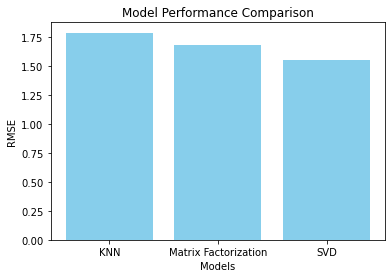

In [16]:
import matplotlib.pyplot as plt

models = ['KNN', 'Matrix Factorization', 'SVD']
rmse_values = [1.79, 1.68, 1.55]

plt.bar(models, rmse_values, color='skyblue')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model Performance Comparison')
plt.show()


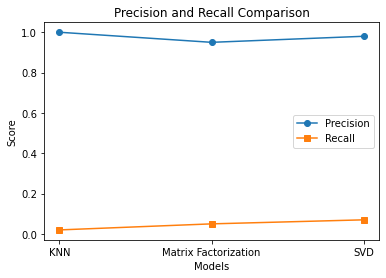

In [17]:
precision = [1.0, 0.95, 0.98]
recall = [0.02, 0.05, 0.07]

plt.plot(models, precision, marker='o', label='Precision')
plt.plot(models, recall, marker='s', label='Recall')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Precision and Recall Comparison')
plt.legend()
plt.show()


#### To integrate the model with website install flask and pickle and then save the model



In [ ]:
import pickle

# Save the model
with open('knn_model.pkl', 'wb') as file:
    pickle.dump(knn, file)

print("Model saved successfully!")

In [19]:
import numpy as np

# If it's a DataFrame
user_item_matrix.to_csv('user_item_matrix.csv', index=False)

# If it's a NumPy array
np.save('user_item_matrix.npy', user_item_matrix)
print("Matrix saved!")


Matrix saved!


### Next Steps

Import the model into vscode by pickel and also the Dataset. 

Once done code the front end and run in terminal

command: python app.py

Open the http://127.0.0.1:5000/